# Importing the packages/libraries and our datasets

In [1]:
# Import required packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# import geopandas as gpd
# import contextily as cx


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve,\
    make_scorer

In [2]:
df_test = pd.read_csv('data/test_set_values.csv')
df_train = pd.read_csv('data/training_set_values.csv')
df_train_label = pd.read_csv('data/training_set_labels.csv')

In [3]:
# Reassigning targets to establish bionomial targets
target = df_train_label.replace({'status_group': {'functional' : 1, 
                                'non functional' : 0, 
                                'functional needs repair' : 0}})
df = pd.concat([df_train, target], axis = 1)

---
# EDA and Datacleaning

# Eliminating features that we found to be redudant or unuseable for our models. 

Many of the features had the same information provided by similar features in the dataset so we trimmed them. In addition to this some features like 'num_private' had no feature descriptions explaining what it was so we could not utilize it.

In [5]:
# Removing columns that are non-factors for our model
col_to_delete = ['id', 'recorded_by', 'funder', 'public_meeting',
                'lga', 'ward', 'region_code', 'district_code', 
                 'wpt_name','scheme_name', 'extraction_type', 'extraction_type_group',
                 'payment', 'quality_group', 'source_type', 'quantity_group',
                 'waterpoint_type_group', 'subvillage', 'num_private']
                 
df2 = df.drop(col_to_delete, axis = 1)

We created a new feature 'year_recorded' to capture only the year that the data was recorded to transform the 'date_recorded'. This was because we believed that this may have been important to keep in our data, but keeping it in its original state may have cause our model to be too complex with the sheer number of unique values.

In [6]:
# Remove duplicated data entries and null values
df2.drop_duplicates(keep='first', inplace = True) 
df2 = df2.dropna(axis = 0)

# Pulling the year off and type casting to int
df2['year_recorded'] = [int(val[0:4]) for val in df2['date_recorded']]
df2['year_recorded'].astype(np.int64)
df2.drop(['date_recorded'], axis = 'columns', inplace = True)

C:\Users\Jun\AppData\Local\Temp/ipykernel_36196/1351887214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop_duplicates(keep='first', inplace = True)


We applied the same thought processes to the following features. In addition we dropped any data that was entered before 2005 as it only comprised 0.06% of our data and created additional problems when attempting to train test split our data.

In [7]:
# Binning the years into decades
df2['construction_year'] = ['unknown' if val == 0 
                           else str((val // 10) * 10) for val in df2['construction_year']]

# Binning the unique values
scheme_management_list = ['SWC', 'Trust', 'None']
df2['scheme_management'].replace(scheme_management_list, 'Other', inplace = True)

In [8]:
# Binning unique values
installer_list = ['DWE', 'Government', 'Commu', 'DANIDA', 
                  'RWE', 'KKKT', 'TCRS']
df2['installer'] = ['Other' if val not in installer_list 
                           else val for val in df2['installer']]

df2.drop(df2.index[df2['year_recorded'] < 2005], inplace=True)
df2.reset_index(inplace=True, drop=True)

---
# Modeling

Simple functions for One Hot Encoding and Scaling our data

In [9]:
def num_encoder(df_to_encode):
    ss = StandardScaler()

    ss.fit(df_to_encode)
    nums_df = pd.DataFrame(ss.transform(df_to_encode),
                           columns = df_to_encode.columns,
                          index = df_to_encode.index)
    return nums_df

def cat_encoder(df_to_encode):
    ohe = OneHotEncoder(
        drop = 'first',
        sparse = False)
    
    dums = ohe.fit_transform(df_to_encode)
    dums_df = pd.DataFrame(dums,
                            columns = ohe.get_feature_names(),
                            index = df_to_encode.index)
    return dums_df

---
# Establishing the Dummy Model

In [10]:
y = df2.status_group
X = df2.drop('status_group', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, random_state=69)

In [11]:
X_train_cat = X_train.select_dtypes('object')
X_train_nums = X_train.select_dtypes(['float64', 'int64'])

X_test_cat = X_test.select_dtypes('object')
X_test_nums = X_test.select_dtypes(['float64', 'int64'])

In [12]:
cont_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop = 'first'))
])

trans = ColumnTransformer(transformers=[
    ('continuous', cont_pipeline, X_train_nums.columns),
    ('categorical', cat_pipeline, X_train_cat.columns)
])

dummy = Pipeline(steps=[
    ('trans', trans),
    ('dummy', DummyClassifier(random_state = 69, strategy = 'most_frequent'))
])

#Fitting and checking the score
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.5461215656259073

Our dummy model predictably produces a score of 54% because it is based on the majority target.

---
# Model 1 (Decision Tree Classifier)

We decided to use a decision tree as our first model for feature selection. For the first iteration we did not specify any hyper-parameters except for the random state.

In [13]:
X_train_clean = pd.concat([num_encoder(X_train_nums), cat_encoder(X_train_cat)], axis = 1)
X_test_clean = pd.concat([num_encoder(X_test_nums), cat_encoder(X_test_cat)], axis = 1)

In [14]:
decision_tree = DecisionTreeClassifier(random_state = 69)
decision_tree.fit(X_train_clean, y_train)

DecisionTreeClassifier(random_state=69)

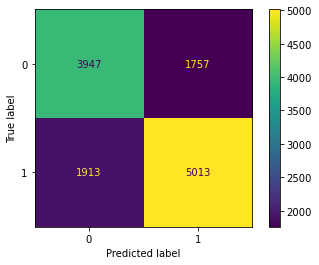

In [15]:
y_tree_train = decision_tree.predict(X_train_clean)
y_tree_test = decision_tree.predict(X_test_clean)
plot_confusion_matrix(decision_tree, X_test_clean, y_test);

In [16]:
display(accuracy_score(y_train, y_tree_train))
display(accuracy_score(y_test, y_tree_test))

0.9972287471297738

0.7094220110847189

In [17]:
display(precision_score(y_train, y_tree_train))
display(precision_score(y_test, y_tree_test))

0.99854700440742

0.7404726735598227

Unsurprisingly the model is severly overfit with an accuracy score of 99% and precision score of 99% on the training set in comparison to the accuracy score of 70% and precision score of 74% on our testing set.

---
# Grid Search for Model 2 Optimal Parameters

We utilized Grid Search to find the optimal hyper-parameters for our Decision Tree model.

In [18]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_clean, y_train)

DecisionTreeClassifier()

In [19]:
param_dict = {
    "criterion":['gini', 'entropy'],
    "max_depth":[1, 10, 25, 50],
    "min_samples_split":range(1, 10),
    "min_samples_leaf":range(1, 10)
}

In [20]:
# tw = GridSearchCV(estimator=decision_tree,
#                  param_grid=param_dict,
#                  cv=5,
#                  verbose=1,
#                  n_jobs=-1)
# tw.fit(X_train_clean, y_train)

In [21]:
# print(tw.best_params_)
# print(tw.best_estimator_)
# print(tw.best_score_)

Here we found that the best parameters for our Decision Tree model are <br>`criterion = 'gini', max_depth = 25, min_samples_leaf = 7`

Kept getting different `min_samples_split` value without results changing so it seems `criterion`, `max_depth`, & and `min_samples_leaf` give us a consistent enough result that `min_samples_split` does not need to be manipulated by us.

---
# Model 2 (Decision Tree) with optimized parameters

In [22]:
decision_tree_better = DecisionTreeClassifier(random_state = 69, criterion = 'gini', 
                                              max_depth = 25, min_samples_leaf = 7)
decision_tree_better.fit(X_train_clean, y_train)

DecisionTreeClassifier(max_depth=25, min_samples_leaf=7, random_state=69)

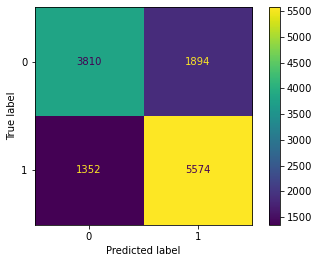

In [23]:
y_tree_train_better = decision_tree_better.predict(X_train_clean)
y_tree_test_better = decision_tree_better.predict(X_test_clean)
plot_confusion_matrix(decision_tree_better, X_test_clean, y_test);

In [24]:
display(accuracy_score(y_train, y_tree_train_better))
display(precision_score(y_train, y_tree_train_better))

0.8751616564174298

0.8781030888762554

In [25]:
display(accuracy_score(y_test, y_tree_test_better))
display(precision_score(y_test, y_tree_test_better))

0.7429928741092636

0.7463845741831816

In [26]:
# y_tt_clean = decision_tree_better.predict(X_tt_clean)

---

[1.51251416e-02 7.18582707e-02 1.38311719e-01 1.35660814e-01
 4.69475040e-02 9.42871589e-03 1.26392545e-03 1.01614341e-02
 5.84869439e-03 9.23210828e-04 1.16282967e-02 2.94179221e-03
 1.41929419e-03 4.99353574e-03 3.08382554e-03 4.74565862e-03
 4.54869374e-03 5.48770412e-03 4.71784609e-03 4.14913527e-03
 5.09628788e-03 9.73505183e-04 2.57831956e-03 1.04709862e-02
 2.39947464e-03 2.45832498e-03 3.56668374e-03 1.82647492e-03
 2.56793737e-03 1.81480319e-03 2.49997015e-03 2.26027721e-03
 2.45413517e-03 2.20604035e-03 3.13170181e-03 2.27390408e-03
 2.47738374e-03 2.39819182e-03 1.41410570e-03 1.71241560e-03
 2.82260635e-03 1.33674860e-03 1.21728128e-03 1.37450399e-03
 6.76448048e-03 2.16724570e-03 2.81616641e-03 3.93565601e-03
 3.78795906e-03 1.37845473e-02 1.01816119e-02 6.91158549e-03
 7.48867355e-03 1.21629063e-02 1.27867049e-02 5.95918561e-03
 9.15459291e-03 4.03379123e-03 2.73197497e-02 7.63269027e-04
 7.75968432e-03 4.53293040e-04 8.22826244e-04 2.25503341e-04
 1.41295933e-03 2.598289

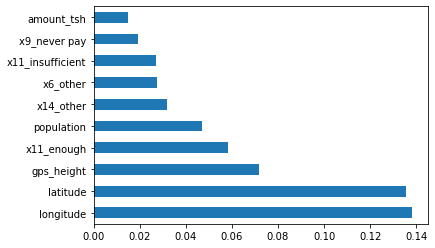

In [27]:
model = ExtraTreesClassifier()
model.fit(X_train_clean, y_train)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index = X_train_clean.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

In [28]:
X_train_cat.columns

Index(['installer', 'basin', 'region', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'water_quality', 'quantity',
       'source', 'source_class', 'waterpoint_type'],
      dtype='object')

In [29]:
df2['waterpoint_type'].value_counts()

communal standpipe             25019
hand pump                      14022
communal standpipe multiple     5854
other                           4874
improved spring                  661
cattle trough                     83
dam                                6
Name: waterpoint_type, dtype: int64

In [30]:
importance_col = ['longitude', 'latitude', 'gps_height', 'quantity', 
                  'status_group', 'population', 'waterpoint_type', 
                 'extraction_type_class', 'payment_type', 'amount_tsh']
df_importance = df2[importance_col]

In [31]:
y2 = df_importance.status_group
X2 = df_importance.drop('status_group', axis = 1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, 
                                                        test_size = 0.25, random_state = 69)

In [32]:
X_train_cat2 = X_train2.select_dtypes('object')
X_train_nums2 = X_train2.select_dtypes(['float64', 'int64'])

X_test_cat2 = X_test2.select_dtypes('object')
X_test_nums2 = X_test2.select_dtypes(['float64', 'int64'])

In [33]:
X_train_clean2 = pd.concat([num_encoder(X_train_nums2), cat_encoder(X_train_cat2)], axis=1)
X_test_clean2 = pd.concat([num_encoder(X_test_nums2), cat_encoder(X_test_cat2)], axis=1)

In [34]:
logreg_clf2 = LogisticRegression(random_state = 69, max_iter = 1000)
logreg_model2 = logreg_clf2.fit(X_train_clean2, y_train2)

In [35]:
logreg_train_pred2 = logreg_clf2.predict(X_train_clean2)
logreg_train_acc2 = accuracy_score(y_train2, logreg_train_pred2)

log_val_preds2 = logreg_clf2.predict(X_test_clean2) # y_hat
log_val_accuracy2 = accuracy_score(y_test2, log_val_preds2)

logreg_train_acc2, log_val_accuracy2

(0.7305550423605796, 0.7315914489311164)

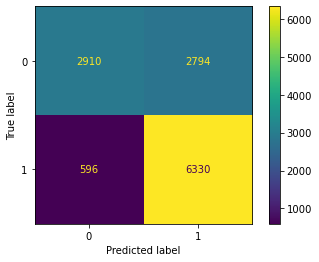

In [36]:
plot_confusion_matrix(logreg_clf2, X_test_clean2, y_test2);

In [37]:
display(precision_score(y_train2, logreg_train_pred2))
display(precision_score(y_test2, log_val_preds2))

0.691708423247138

0.6937746602367383

---

In [38]:
logreg_clf = LogisticRegression(random_state = 69, max_iter = 1000)
logreg_model = logreg_clf.fit(X_train_clean, y_train)

In [39]:
logreg_train_pred = logreg_clf.predict(X_train_clean)
logreg_train_acc = accuracy_score(y_train, logreg_train_pred)

log_val_preds = logreg_clf.predict(X_test_clean) # y_hat
log_val_accuracy = accuracy_score(y_test, log_val_preds)

logreg_train_acc, log_val_accuracy

(0.7625696112328116, 0.7629453681710214)

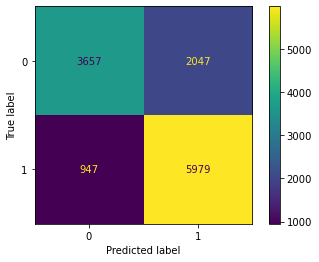

In [40]:
plot_confusion_matrix(logreg_clf, X_test_clean, y_test);

In [41]:
display(precision_score(y_train, logreg_train_pred))

display(precision_score(y_test, log_val_preds))

0.745734935708883

0.7449538998255669

In [42]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_clean, y_train)
grid = {
    'n_neighbors': range(1, 15),
    'metric': ['manhattan'],
    'weights' : ['distance']
}

In [43]:
# gs = GridSearchCV(estimator = knn_model, param_grid = grid, cv = 5, verbose = 1, n_jobs = -1)
# gs.fit(X_train_clean, y_train)

In [44]:
# gs.best_params_

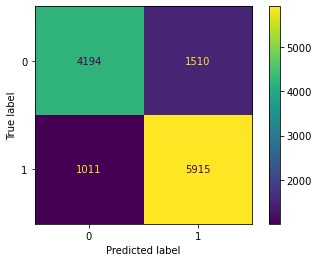

In [45]:
knn_better = KNeighborsClassifier(14, metric = "manhattan", weights = 'distance') 
knn_better.fit(X_train_clean, y_train)

y_knn_better_train = knn_better.predict(X_train_clean)
y_knn_better_test = knn_better.predict(X_test_clean)

plot_confusion_matrix(knn_better, X_test_clean, y_test);

In [46]:
display(accuracy_score(y_train, y_knn_better_train))
display(precision_score(y_train, y_knn_better_train))

0.9972287471297738

0.99854700440742

In [47]:
display(accuracy_score(y_test, y_knn_better_test))
display(precision_score(y_test, y_knn_better_test))

0.8003958828186857

0.7966329966329966

In [48]:
avg = VotingClassifier(estimators=[ ('lr', logreg_model),
                                    ('dt', decision_tree_better),
                                    ('knn', knn_better)],
                                     weights = [0.25, 0.25, 0.5])
avg.fit(X_train_clean, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=69)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=25,
                                                     min_samples_leaf=7,
                                                     random_state=69)),
                             ('knn',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=14,
                                                   weights='distance'))],
                 weights=[0.25, 0.25, 0.5])

In [49]:
scores = cross_val_score(estimator = avg, X = X_train_clean, 
                         y = y_train, cv = 5)
print(np.median(scores))
print(avg.score(X_test_clean, y_test))

0.8043019266297176
0.8064133016627079


In [50]:
print("Acc:", accuracy_score(y_test, avg.predict(X_test_clean)))
print("Prec: ", precision_score(y_test, avg.predict(X_test_clean)))

Acc: 0.8064133016627079
Prec:  0.8164101115661629


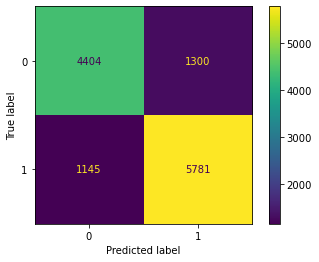

In [51]:
plot_confusion_matrix(avg, X_test_clean, y_test);

In [52]:
cm = confusion_matrix(y_test, avg.predict(X_test_clean))

tp, tn, fp, fn = cm[1][1], cm[0][0], cm[0][1], cm[1][0]
tpr = tp / (tp + fn)
print(tpr)

0.8346809125036095


In [53]:
fpr = fp / (fp + tn)
print(fpr)

0.22791023842917252


In [54]:
proba_work = y_test.value_counts()[1] / y_test.value_counts().sum()
proba_work

0.5483768804433887

In [55]:
W = .55 
PW = .7
NPW = .3

NW = .45
PNW = .65
NPNW = .35

In [56]:
thisshitbetterwork = (PW * W) / ((W * PW) + (NW * PNW))
thisshitbetterwork

0.5682656826568266

In [57]:
fuckyou = (NPNW * NW) / ((W * NPW) + (NW * NPNW))
fuckyou

0.4883720930232558

In [58]:
proba_permit = X_test['permit'].value_counts()[1] / X_test['permit'].value_counts().sum()
proba_permit

0.6865399841646872

In [59]:
proba_df = df2[['permit', 'status_group']].copy()
filtered_1 = proba_df.loc[proba_df['status_group'] == 1]
filtered_1['permit'].value_counts(normalize=True)

True     0.704649
False    0.295351
Name: permit, dtype: float64

In [60]:
proba_df = df2[['permit', 'status_group']].copy()
filtered_2 = proba_df.loc[proba_df['status_group'] == 0]
filtered_2['permit'].value_counts(normalize=True)

True     0.659797
False    0.340203
Name: permit, dtype: float64

---

In [61]:
df3 = df_test.drop(col_to_delete, axis = 1)

In [62]:
df3.drop_duplicates(keep = 'first',inplace = True)
df3 = df3.dropna(axis = 0)

df3['year_recorded'] = [int(val[0:4]) for val in df3['date_recorded']]
df3['year_recorded'].astype(np.int64)
df3.drop(['date_recorded'], axis = 'columns', inplace = True)

In [63]:
df3['construction_year'] = ['unknown' if val == 0 
                           else str((val // 10) * 10) for val in df3['construction_year']]
df3['scheme_management'].replace(scheme_management_list, 'Other', inplace=True)
df3['installer'] = ['Other' if val not in installer_list 
                           else val for val in df3['installer']]

In [64]:
df3.drop(df3.index[df3['year_recorded'] < 2005], inplace = True)

In [65]:
Ftest_cat = df3.select_dtypes('object')
Ftest_nums = df3.select_dtypes(['float64', 'int64'])

In [66]:
Ftest = pd.concat([num_encoder(Ftest_nums), cat_encoder(Ftest_cat)], axis=1)

In [67]:
df3['targets'] = avg.predict(Ftest)

Combined 0 and 1

In [68]:
# drop_zeros = df3.loc[(df3['longitude'] != 0.0) & (df3['latitude'] != 0.0)]

# fig, ax = plt.subplots(figsize=(18,12))

# countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# drop_zeros
# sns.scatterplot(x = drop_zeros['longitude'], y = drop_zeros['latitude'], hue = drop_zeros["targets"], \
#                 palette = ["red", "blue"], alpha = .5)

# ax.grid(b=True, alpha=0.5)

# cx.add_basemap(ax, crs=countries.crs.to_string())

# ax.set(title='Combined Wells, 0 = Broken, 1 = Working')
# plt.legend(title='Wells', loc='upper right', labels=['Need Repair', 'Working'])

# plt.show()

# fig.savefig("combo.png")

# Appendix

Need Repair

In [69]:
# temp_0 = df3.loc[(df3['longitude'] != 0.0) & (df3['latitude'] != 0.0)]


# temp_00 = temp_0.loc[(df3['targets'] == 0)]

# dropper = temp_00

# fig, ax = plt.subplots(figsize=(18,12))

# countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# sns.scatterplot(x = dropper['longitude'], y = dropper['latitude'], color = "red", alpha = .5)

# ax.grid(b=True, alpha=0.5)

# cx.add_basemap(ax, crs=countries.crs.to_string())
# ax.set(title='Need Repair')


# plt.show()
# fig.savefig("need_repair.png")

Functional Wells

In [70]:
# temp_1 = df3.loc[(df3['longitude'] != 0.0) & (df3['latitude'] != 0.0)]


# temp_11 = temp_1.loc[(df3['targets'] == 1)]

# dropper_1 = temp_11

# fig, ax = plt.subplots(figsize=(18,12))

# countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


# sns.scatterplot(x = dropper_1['longitude'], y = dropper_1['latitude'], color = "blue", alpha = .5)

# ax.grid(b=True, alpha=0.5)

# cx.add_basemap(ax, crs=countries.crs.to_string())

# ax.set(title='Functioning Wells')

# plt.show()

 
# fig.savefig("working.png")